# Baseline Models: GCN and XGBoost (Pooled Training)

## Purpose
This notebook provides **fair baseline comparisons** for sequential models by:
1. Using the same timestep filtering (threshold >= 25 illicit transactions)
2. Using the same temporal 80-20 split on valid timesteps
3. Training on **pooled** train/test sets (NOT sequential)

## Approach
- **Timestep Filtering**: Remove timesteps with < 25 illicit transactions
- **Temporal Split**: First 80% of valid timesteps for training, last 20% for testing
- **Pooled Training**: All training timesteps combined into single dataset
- **Models**: GCN (50 epochs) and XGBoost
- **Evaluation**: Pooled test set metrics for direct comparison

## 1. Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Loading data...")
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]
print("Data loaded successfully!")

c:\Github\BT4012_elliptic\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...
Data loaded successfully!


In [2]:
# Preprocess data
print("Preprocessing data...")

# Map classes: 'unknown'=0, '1'=1 (illicit), '2'=2 (licit)
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})

# Merge class labels into features
df = features_df.merge(classes_df, on='txId', how='left')

# Create node ID mapping
node_ids = df['txId'].values
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Prepare Edge Index for GCN
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Prepare Features and Labels tensors
x = torch.tensor(df.iloc[:, 2:-1].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.long)
time_steps = torch.tensor(df['time_step'].values, dtype=torch.long)

print(f"Nodes: {x.shape[0]}, Edges: {edge_index.shape[1]}, Features: {x.shape[1]}")
print(f"Label distribution: Unknown={sum(y==0)}, Illicit={sum(y==1)}, Licit={sum(y==2)}")

Preprocessing data...
Nodes: 203769, Edges: 234355, Features: 165
Label distribution: Unknown=157205, Illicit=4545, Licit=42019


## 2. Timestep Filtering (Threshold >= 25 illicit)

In [3]:
ILLICIT_THRESHOLD = 25

# Calculate illicit count per timestep
valid_timesteps = []
dropped_timesteps = []

print(f"Analyzing timesteps (Threshold >= {ILLICIT_THRESHOLD} illicit txs)...")
for t in range(1, 50):
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    if n_illicit >= ILLICIT_THRESHOLD:
        valid_timesteps.append(t)
    else:
        dropped_timesteps.append((t, n_illicit))

print(f"\nDropped {len(dropped_timesteps)} timesteps:")
for t, count in dropped_timesteps:
    print(f"  T{t}: {count} illicit txs")

print(f"\nValid Timesteps ({len(valid_timesteps)}): {valid_timesteps}")

Analyzing timesteps (Threshold >= 25 illicit txs)...

Dropped 14 timesteps:
  T1: 17 illicit txs
  T2: 18 illicit txs
  T3: 11 illicit txs
  T5: 8 illicit txs
  T6: 5 illicit txs
  T10: 18 illicit txs
  T12: 16 illicit txs
  T27: 24 illicit txs
  T33: 23 illicit txs
  T43: 24 illicit txs
  T44: 24 illicit txs
  T45: 5 illicit txs
  T46: 2 illicit txs
  T47: 22 illicit txs

Valid Timesteps (35): [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49]


## 3. Temporal 80-20 Split on Valid Timesteps

In [4]:
# Split valid timesteps: 80% train, 20% test
num_valid = len(valid_timesteps)
split_idx = int(num_valid * 0.8)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Total Valid Timesteps: {num_valid}")
print(f"Training Timesteps ({len(train_timesteps)}): {train_timesteps}")
print(f"Testing Timesteps ({len(test_timesteps)}): {test_timesteps}")

# Create pooled train/test masks
train_mask_pooled = torch.zeros(len(y), dtype=torch.bool)
test_mask_pooled = torch.zeros(len(y), dtype=torch.bool)

for t in train_timesteps:
    train_mask_pooled |= ((time_steps == t) & (y > 0))

for t in test_timesteps:
    test_mask_pooled |= ((time_steps == t) & (y > 0))

# Statistics
n_train = train_mask_pooled.sum().item()
n_test = test_mask_pooled.sum().item()
n_train_illicit = ((y[train_mask_pooled] == 1).sum().item())
n_test_illicit = ((y[test_mask_pooled] == 1).sum().item())
n_train_licit = ((y[train_mask_pooled] == 2).sum().item())
n_test_licit = ((y[test_mask_pooled] == 2).sum().item())

print(f"\nPooled Training Set:")
print(f"  Total nodes: {n_train}")
print(f"  Illicit: {n_train_illicit} ({n_train_illicit/n_train*100:.2f}%)")
print(f"  Licit: {n_train_licit} ({n_train_licit/n_train*100:.2f}%)")

print(f"\nPooled Test Set:")
print(f"  Total nodes: {n_test}")
print(f"  Illicit: {n_test_illicit} ({n_test_illicit/n_test*100:.2f}%)")
print(f"  Licit: {n_test_licit} ({n_test_licit/n_test*100:.2f}%)")

Total Valid Timesteps: 35
Training Timesteps (28): [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37]
Testing Timesteps (7): [38, 39, 40, 41, 42, 48, 49]

Pooled Training Set:
  Total nodes: 24406
  Illicit: 3577 (14.66%)
  Licit: 20829 (85.34%)

Pooled Test Set:
  Total nodes: 7383
  Illicit: 751 (10.17%)
  Licit: 6632 (89.83%)


## 4. GCN Baseline (Pooled Training)

In [5]:
# GCN Model Definition
class GCNFraudDetector(torch.nn.Module):
    def __init__(self, in_features, hidden=64, out_classes=3, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(in_features, hidden)
        self.gcn2 = GCNConv(hidden, hidden // 2)
        self.fc = torch.nn.Linear(hidden // 2, out_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Helper function for class weights
def compute_class_weights(labels, device):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    if n_illicit == 0: 
        weight_illicit = 1.0
    else: 
        weight_illicit = total / (2.0 * n_illicit)
        
    if n_licit == 0: 
        weight_licit = 1.0
    else: 
        weight_licit = total / (2.0 * n_licit)
        
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

# Evaluation function
@torch.no_grad()
def evaluate(model, x, edge_index, mask, y):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    y_true = y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    y_probs = probs[mask][:, 1].cpu().numpy()
    
    # Binary conversion (1=illicit, 0=licit)
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    return {
        'accuracy': accuracy_score(y_true_bin, y_pred_bin),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'auc_roc': roc_auc_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.5,
        'pr_auc': average_precision_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.0
    }

In [7]:
# Initialize GCN model
model_gcn = GCNFraudDetector(in_features=x.shape[1]).to(device)
optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.01)

# Move data to device
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)
train_mask_pooled = train_mask_pooled.to(device)
test_mask_pooled = test_mask_pooled.to(device)

# Compute class weights
class_weights = compute_class_weights(y[train_mask_pooled], device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"Class weights: Illicit={class_weights[1]:.4f}, Licit={class_weights[2]:.4f}")

Class weights: Illicit=3.4115, Licit=0.5859


In [8]:
# Train GCN (50 epochs on pooled training set)
NUM_EPOCHS = 50

print("Training GCN on pooled training set...")
print(f"Epochs: {NUM_EPOCHS}")
print("-" * 50)

for epoch in range(1, NUM_EPOCHS + 1):
    model_gcn.train()
    optimizer_gcn.zero_grad()
    out = model_gcn(x, edge_index)
    loss = criterion(out[train_mask_pooled], y[train_mask_pooled])
    loss.backward()
    optimizer_gcn.step()
    
    if epoch % 10 == 0:
        train_metrics = evaluate(model_gcn, x, edge_index, train_mask_pooled, y)
        test_metrics = evaluate(model_gcn, x, edge_index, test_mask_pooled, y)
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | "
              f"Train F1: {train_metrics['f1']:.4f} | Test F1: {test_metrics['f1']:.4f}")

print("\nGCN Training Complete!")

Training GCN on pooled training set...
Epochs: 50
--------------------------------------------------
Epoch 010 | Loss: 0.4949 | Train F1: 0.5490 | Test F1: 0.3636
Epoch 020 | Loss: 0.4157 | Train F1: 0.6111 | Test F1: 0.4137
Epoch 030 | Loss: 0.3758 | Train F1: 0.6260 | Test F1: 0.4197
Epoch 040 | Loss: 0.3467 | Train F1: 0.6579 | Test F1: 0.4622
Epoch 050 | Loss: 0.3250 | Train F1: 0.6878 | Test F1: 0.4864

GCN Training Complete!


In [9]:
# Final GCN evaluation
gcn_metrics = evaluate(model_gcn, x, edge_index, test_mask_pooled, y)

print("=" * 80)
print("GCN BASELINE - POOLED TEST SET METRICS")
print("=" * 80)
print(f"Accuracy:  {gcn_metrics['accuracy']*100:.2f}%")
print(f"Precision: {gcn_metrics['precision']*100:.2f}%")
print(f"Recall:    {gcn_metrics['recall']*100:.2f}%")
print(f"F1 Score:  {gcn_metrics['f1']*100:.2f}%")
print(f"AUC-ROC:   {gcn_metrics['auc_roc']:.4f}")
print(f"PR-AUC:    {gcn_metrics['pr_auc']:.4f}")
print("=" * 80)

GCN BASELINE - POOLED TEST SET METRICS
Accuracy:  87.19%
Precision: 41.06%
Recall:    59.65%
F1 Score:  48.64%
AUC-ROC:   0.8663
PR-AUC:    0.5639


## 5. XGBoost Baseline (Pooled Training)

In [10]:
# Prepare data for XGBoost (features only, no graph structure)
X_all = df.iloc[:, 2:-1].values
y_all = df['class'].values
time_all = df['time_step'].values

# Convert to binary labels (1=illicit, 0=licit/unknown)
# Filter to labeled data only
labeled_mask = (y_all == 1) | (y_all == 2)
X_labeled = X_all[labeled_mask]
y_binary = (y_all[labeled_mask] == 1).astype(int)
time_labeled = time_all[labeled_mask]

# Create train/test masks based on valid timesteps
train_mask_xgb = np.isin(time_labeled, train_timesteps)
test_mask_xgb = np.isin(time_labeled, test_timesteps)

X_train = X_labeled[train_mask_xgb]
y_train = y_binary[train_mask_xgb]
X_test = X_labeled[test_mask_xgb]
y_test = y_binary[test_mask_xgb]

print(f"XGBoost Training set: {len(X_train)} samples")
print(f"  Illicit: {y_train.sum()}, Licit: {(1-y_train).sum()}")
print(f"XGBoost Test set: {len(X_test)} samples")
print(f"  Illicit: {y_test.sum()}, Licit: {(1-y_test).sum()}")

XGBoost Training set: 24406 samples
  Illicit: 3577, Licit: 20829
XGBoost Test set: 7383 samples
  Illicit: 751, Licit: 6632


In [11]:
# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

# Parameter grid for XGBoost
param_grid = {
    'reg_alpha': [0.1, 1.0, 10.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
}

base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100
)

print("Starting XGBoost GridSearchCV...")
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

model_xgb = grid_search.best_estimator_

XGBoost scale_pos_weight: 5.82
Starting XGBoost GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV ROC-AUC: 0.9950


In [12]:
# XGBoost evaluation
y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

xgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_xgb, zero_division=0),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_xgb),
    'pr_auc': average_precision_score(y_test, y_pred_proba_xgb)
}

print("=" * 80)
print("XGBOOST BASELINE - POOLED TEST SET METRICS")
print("=" * 80)
print(f"Accuracy:  {xgb_metrics['accuracy']*100:.2f}%")
print(f"Precision: {xgb_metrics['precision']*100:.2f}%")
print(f"Recall:    {xgb_metrics['recall']*100:.2f}%")
print(f"F1 Score:  {xgb_metrics['f1']*100:.2f}%")
print(f"AUC-ROC:   {xgb_metrics['auc_roc']:.4f}")
print(f"PR-AUC:    {xgb_metrics['pr_auc']:.4f}")
print("=" * 80)

XGBOOST BASELINE - POOLED TEST SET METRICS
Accuracy:  96.94%
Precision: 97.30%
Recall:    71.90%
F1 Score:  82.70%
AUC-ROC:   0.9703
PR-AUC:    0.8927


## 6. Results Comparison

In [13]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['GCN (Pooled)', 'XGBoost (Pooled)'],
    'Accuracy': [gcn_metrics['accuracy'], xgb_metrics['accuracy']],
    'Precision': [gcn_metrics['precision'], xgb_metrics['precision']],
    'Recall': [gcn_metrics['recall'], xgb_metrics['recall']],
    'F1': [gcn_metrics['f1'], xgb_metrics['f1']],
    'ROC-AUC': [gcn_metrics['auc_roc'], xgb_metrics['auc_roc']],
    'PR-AUC': [gcn_metrics['pr_auc'], xgb_metrics['pr_auc']]
})

print("\n" + "=" * 80)
print("BASELINE MODELS COMPARISON (Pooled Test Set)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)


BASELINE MODELS COMPARISON (Pooled Test Set)
           Model  Accuracy  Precision   Recall       F1  ROC-AUC   PR-AUC
    GCN (Pooled)  0.871868   0.410632 0.596538 0.486428 0.866270 0.563883
XGBoost (Pooled)  0.969389   0.972973 0.719041 0.826953 0.970285 0.892729


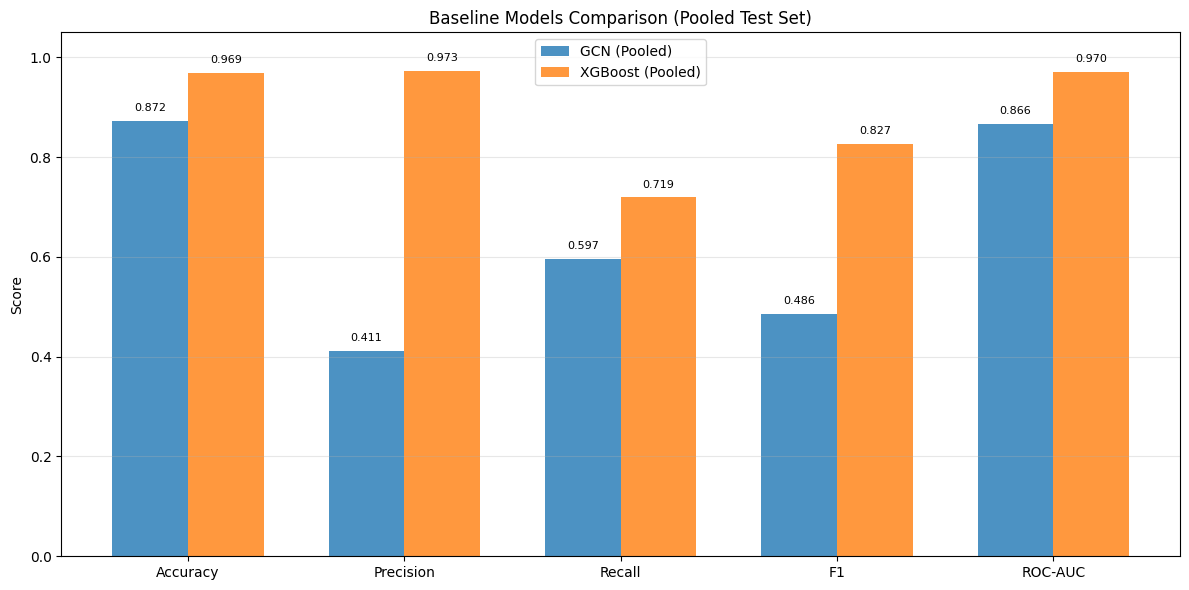

In [14]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.35

gcn_values = [gcn_metrics['accuracy'], gcn_metrics['precision'], 
              gcn_metrics['recall'], gcn_metrics['f1'], gcn_metrics['auc_roc']]
xgb_values = [xgb_metrics['accuracy'], xgb_metrics['precision'], 
              xgb_metrics['recall'], xgb_metrics['f1'], xgb_metrics['auc_roc']]

ax.bar(x_pos - width/2, gcn_values, width, label='GCN (Pooled)', alpha=0.8)
ax.bar(x_pos + width/2, xgb_values, width, label='XGBoost (Pooled)', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Baseline Models Comparison (Pooled Test Set)')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.05)

# Add value labels on bars
for i, (gcn_val, xgb_val) in enumerate(zip(gcn_values, xgb_values)):
    ax.text(i - width/2, gcn_val + 0.02, f'{gcn_val:.3f}', ha='center', fontsize=8)
    ax.text(i + width/2, xgb_val + 0.02, f'{xgb_val:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## Summary

This notebook provides baseline results for:
- **GCN (Pooled)**: Graph Convolutional Network trained for 50 epochs on the pooled training set
- **XGBoost (Pooled)**: XGBoost trained on the pooled training set (features only)

Both models use:
- Same timestep filtering (>= 25 illicit transactions)
- Same temporal 80-20 split on valid timesteps
- Pooled training (all train timesteps combined)
- Pooled test evaluation (all test timesteps combined)

These results can be directly compared to sequential models that use the same filtered timesteps.